# Assignment 2: Convolutional Neural Networks and AutoML
---

# Import Required Libraries
Import the necessary libraries, including PyTorch and the chosen hyperparameter optimization library.

In [9]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from support import load_dataset
import matplotlib.pyplot as plt
from torch.utils.data import random_split

# Importing hyperparameter optimization library
import optuna
# from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Load and Preprocess the Wefabricate Dataset
Load the Wefabricate dataset and preprocess it for use with a CNN.

In [10]:
train_data, test_data = load_dataset()

print(f"Train data: {len(train_data)}")
print(f"Test data: {len(test_data)}")

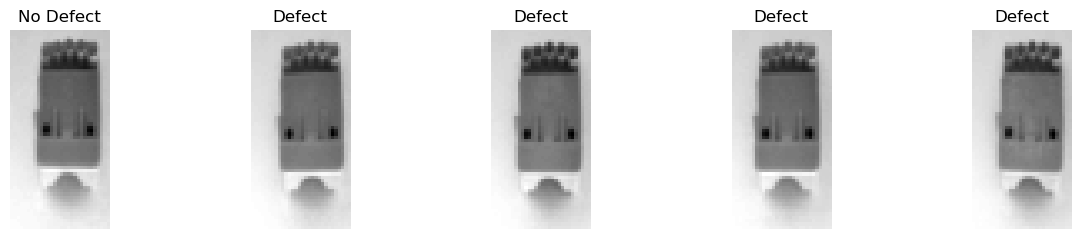

In [11]:
# Visualize data with their labels

# Define the class labels 
class_labels = ["Defect", "No Defect"]

# Get a batch of training data
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
images, labels = next(iter(train_loader))

# Create a grid of the images and print the labels
plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.axis('off')
    plt.title(class_labels[labels[i]])
    
plt.show()

# Define the CNN Model
Define a CNN to classify product images in the Wefabricate dataset.

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(3, 3)
        self.fc1 = nn.Linear(16 * 8 * 3, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(84, 1)

        # Initialize weights with Kaiming Normal
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.pool1(self.bn1(F.relu(self.conv1(x))))
        x = self.pool2(self.bn2(F.relu(self.conv2(x))))
        x = x.view(-1, 16 * 8 * 3)
        x = self.dropout1(self.bn3(F.relu(self.fc1(x))))
        x = self.dropout2(self.bn4(F.relu(self.fc2(x))))
        x = torch.sigmoid(self.fc3(x))
        return x.squeeze()

# Train the CNN Model
Train the CNN model on the training set.

In [13]:
def train_model(model, dataset, criterion, optimizer, device, n_epochs=10, val_split=0.1):
    # Create train and validation splits
    val_size = int(val_split * len(dataset))
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):  
        # Training
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
        avg_val_loss = running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

    print('Finished Training')
    return train_losses, val_losses

In [14]:
# Instantiate the network
model = SimpleCNN()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Move the model to the device
model.to(device)
model.train()

train_losses, val_losses = train_model(model, train_data, criterion, optimizer, device, n_epochs=100)

Epoch 1, Train Loss: 1.0230258703231812, Val Loss: 0.7088991403579712
Epoch 2, Train Loss: 0.7237586379051208, Val Loss: 0.6330890655517578
Epoch 3, Train Loss: 0.6288333237171173, Val Loss: 0.6021528244018555
Epoch 4, Train Loss: 0.6267354488372803, Val Loss: 0.5642793774604797
Epoch 5, Train Loss: 0.5375501066446304, Val Loss: 0.5245218276977539
Epoch 6, Train Loss: 0.4196328818798065, Val Loss: 0.4668237864971161
Epoch 7, Train Loss: 0.41323021054267883, Val Loss: 0.4023744761943817
Epoch 8, Train Loss: 0.3182726055383682, Val Loss: 0.34023845195770264
Epoch 9, Train Loss: 0.34110671281814575, Val Loss: 0.284629762172699
Epoch 10, Train Loss: 0.30919045209884644, Val Loss: 0.24698993563652039
Epoch 11, Train Loss: 0.30144330859184265, Val Loss: 0.21110039949417114
Epoch 12, Train Loss: 0.2966896742582321, Val Loss: 0.17889276146888733
Epoch 13, Train Loss: 0.20961404591798782, Val Loss: 0.15668006241321564
Epoch 14, Train Loss: 0.23689255118370056, Val Loss: 0.13229992985725403
Epoc

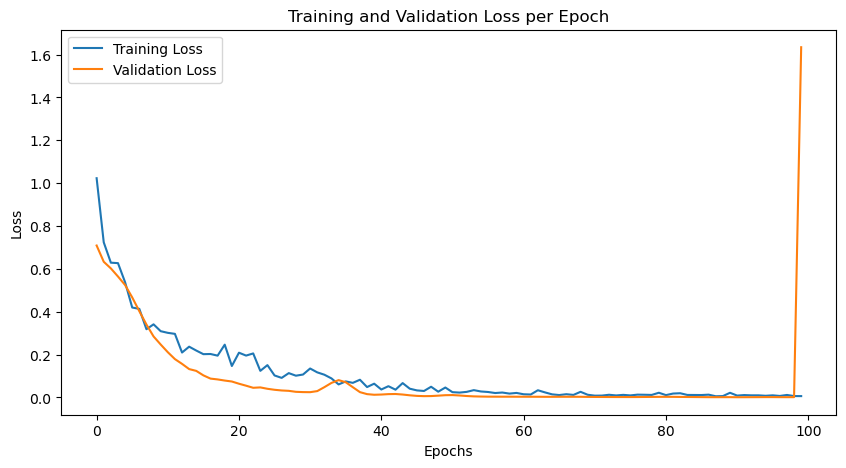

In [15]:
# Visualize the training loss over epochs
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss per Epoch")
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test the CNN Model
Test the trained CNN model on the test set.

In [20]:
def test_model(model, test_data, device):
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
   
    return accuracy

In [21]:
accuracy = test_model(model, test_data, device)
print(f'Accuracy of the model on the test images: {accuracy}%')

torch.save(model.state_dict(), 'models/simple_model.pth')

Accuracy of the model on the test images: 50.0%


# Hyperparameter Selection
Choose five hyperparameters to tune.

# Hyperparameter Optimization with Random Search
Use random search to tune the chosen hyperparameters.

# Hyperparameter Optimization with Sophisticated Method
Use a more sophisticated method than random search to tune the chosen hyperparameters.

# 5-Fold Cross-Validation
Perform 5-fold cross-validation on the training set to calculate the validation accuracy for the hyperparameters.

# Compare Results Before and After Hyperparameter Optimization
Compare the results obtained before and after automatic hyperparameter optimization in terms of accuracy.

# Save Model Weights Before and After Hyperparameter Tuning
Save the trained model weights before and after hyperparameter tuning.